# Asistente Multimodal para Realidad Aumentada

Esta práctica consiste en crear un asistente que combine **voz e imagen**, como si fueran unas gafas de realidad aumentada. El usuario hablará, el sistema entenderá su orden y actuará sobre una imagen (por ejemplo, detectando o resaltando objetos).

- **Entrada:** audio + imagen
- **Salida:** imagen modificada (anotaciones) y, opcionalmente, respuesta por voz.

> 💡 En un sistema real, la entrada visual sería **vídeo**; aquí usamos imágenes por simplicidad. **Se valorará positivamente** que integréis **vídeo** como entrada y/o salida (por ejemplo, procesando clips cortos por frames y superponiendo anotaciones).


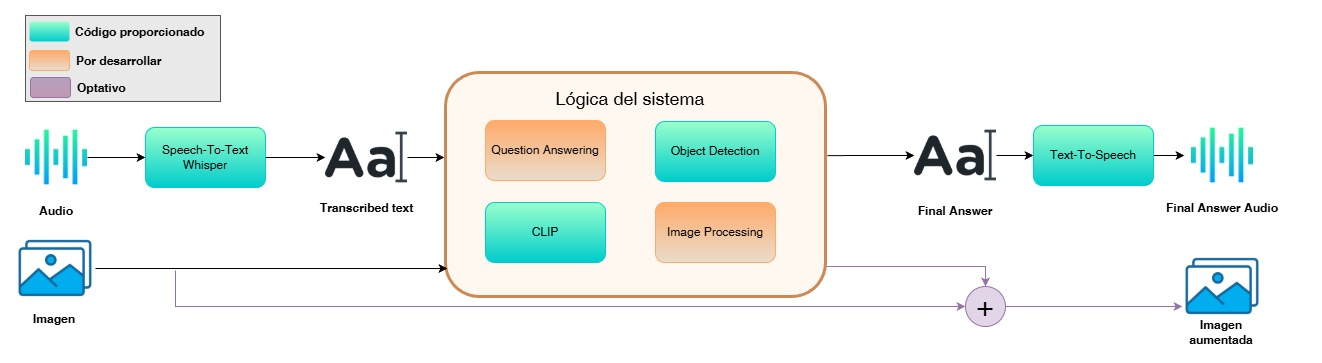

## Funcionalidades sugeridas (elige ≥ 3)
- Conteo: "¿Qué objetos hay en la imagen?" → listar objetos detectados.
- Selección: "Márcame el ``[objeto]``" → dibujar bounding box o resaltado.
- Preguntas: "¿Hay una ``[objeto]``?" → respuesta sí/no con evidencia visual.
- Matching CLIP texto-imagen → buscar lo más parecido a una palabra/frase.
- Describir la escena en una frase.
- Creatividad/avanzado: combinar condiciones ("todas las sillas y mesas")
- Alertas: "Avísame si aparece un coche"
- Aplicar filtros sobre la zona indicada: Ej. anonimiza a las personas
- **Vídeo** (opcional con puntuación extra). Ej. [Supervision Roboflow](https://supervision.roboflow.com/latest/)


In [1]:
# 🔧 Instalación de librerías base
!pip install -q openai-whisper ultralytics git+https://github.com/openai/CLIP.git
!pip install -q moviepy gTTS
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando dispositivo:', device)


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Usando dispositivo: cpu


## 📁 Subir archivos de prueba
Asegúrate de subir al entorno:
- Un archivo de audio (`audio.wav`)
- Una imagen (`imagen.jpg`)
- Opcional: un vídeo (`video.mp4`)

Puedes usar el botón lateral **📎 Files** en Colab para arrastrar archivos.

## 🔊 Whisper – Transcripción de audio a texto
Este bloque convierte un audio hablado en texto. Puedes usar la transcripción para decidir qué acción realizar sobre la imagen.

In [2]:
import whisper
model_whisper = whisper.load_model('base')
def transcribir_audio(ruta_audio):
    resultado = model_whisper.transcribe(ruta_audio)
    return resultado['text']

# Ejemplo de uso:
texto = transcribir_audio('audio.m4a')
print('Texto transcrito:', texto)

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 52.4MiB/s]
c:\Users\alema\anaconda3\envs\idspia\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


RuntimeError: Failed to load audio: ffmpeg version N-117760-gfe18ed3f2a-20241112 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.0 (crosstool-NG 1.26.0.120_4d36f27)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-libxml2 --enable-lzma --enable-fontconfig --enable-libharfbuzz --enable-libvorbis --enable-opencl --disable-libpulse --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-libass --enable-libbluray --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librist --enable-libssh --enable-libtheora --enable-libvpx --enable-libwebp --enable-libzmq --enable-lv2 --enable-libvpl --enable-openal --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopenmpt --enable-librav1e --enable-librubberband --enable-schannel --enable-sdl2 --enable-libsoxr --enable-libsrt --enable-libsvtav1 --enable-libtwolame --enable-libuavs3d --disable-libdrm --enable-vaapi --enable-libvidstab --enable-vulkan --enable-libshaderc --enable-libplacebo --enable-libvvenc --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libzimg --enable-libzvbi --extra-cflags=-DLIBTWOLAME_STATIC --extra-cxxflags= --extra-libs=-lgomp --extra-ldflags=-pthread --extra-ldexeflags= --cc=x86_64-w64-mingw32-gcc --cxx=x86_64-w64-mingw32-g++ --ar=x86_64-w64-mingw32-gcc-ar --ranlib=x86_64-w64-mingw32-gcc-ranlib --nm=x86_64-w64-mingw32-gcc-nm --extra-version=20241112
  libavutil      59. 46.100 / 59. 46.100
  libavcodec     61. 24.100 / 61. 24.100
  libavformat    61.  9.100 / 61.  9.100
  libavdevice    61.  4.100 / 61.  4.100
  libavfilter    10.  6.101 / 10.  6.101
  libswscale      8.  9.101 /  8.  9.101
  libswresample   5.  4.100 /  5.  4.100
  libpostproc    58.  4.100 / 58.  4.100
[in#0 @ 0000024e206c8700] Error opening input: No such file or directory
Error opening input file audio.m4a.
Error opening input files: No such file or directory


## 👁️ YOLO – Detección de objetos en imágenes
Este modelo detecta objetos y devuelve su posición en la imagen. Lo usaremos para resaltar aquello que el usuario pida mediante voz.

In [3]:
from ultralytics import YOLO
from PIL import Image

model_yolo = YOLO('yolov8n.pt')

def detectar_objetos(ruta_imagen):
    resultados = model_yolo(ruta_imagen)
    resultados[0].show()  # Muestra la imagen con bounding boxes
    return resultados[0]

# Ejemplo de uso:
resultado_yolo = detectar_objetos('imagen.jpg')

FileNotFoundError: imagen.jpg does not exist

## 🧠 CLIP – Relación texto-imagen
Este modelo compara una imagen con palabras/frases y devuelve qué texto se parece más al contenido visual.

In [ ]:
import clip
from PIL import Image
import numpy as np

model_clip, preprocess = clip.load("ViT-B/32", device=device)

def clip_matching(ruta_imagen, lista_textos):
    imagen = preprocess(Image.open(ruta_imagen)).unsqueeze(0).to(device)
    textos = clip.tokenize(lista_textos).to(device)
    with torch.no_grad():
        logits_imagen, logits_texto = model_clip(imagen, textos)
        probs = logits_imagen.softmax(dim=-1).cpu().numpy()[0]
    return dict(zip(lista_textos, probs))

# Ejemplo de uso:
print(clip_matching('imagen.jpg', ['una bicicleta', 'una persona', 'un cocina']))

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 79.6MiB/s]


{'una bicicleta': np.float16(0.0004728), 'una persona': np.float16(0.0001851), 'un cocina': np.float16(0.9995)}


## Procesamiento de vídeo (opcional para puntos extra)
Este bloque extrae frames de un vídeo y permite aplicar detección en cada frame.

In [ ]:
from moviepy.editor import VideoFileClip
import os

def procesar_video(ruta_video, funcion_frame, carpeta_salida='frames_out'):
    os.makedirs(carpeta_salida, exist_ok=True)
    clip_video = VideoFileClip(ruta_video)
    for i, frame in enumerate(clip_video.iter_frames()):
        #Iterar por cada frame



##  TTS (Texto a voz opcional)
Convierte la respuesta del asistente en audio.

In [ ]:
from gtts import gTTS
from IPython.display import Audio

def texto_a_voz(texto, archivo='respuesta.mp3'):
    tts = gTTS(texto, lang='es', tld='es')
    tts.save(archivo)
    return Audio(archivo, autoplay=True)

# Ejemplo de uso:
texto_a_voz('La bicicleta ha sido encontrada')

# Pipeline
Aquí es donde integraréis Whisper, YOLO, CLIP y opcionalmente vídeo + TTS.

**Flujo sugerido:**
1. Transcribir audio → obtener orden.
2. Analizar la orden (ej: contiene palabras como 'buscar', 'marcar', 'qué hay...').
3. Usar YOLO, CLIP, VLM + cualquier lógica que le queráis dar
5. Generar salida visual + opcionalmente voz y video.


In [ ]:
# 🧠 Función principal del asistente
def asistente_multimodal(ruta_audio, ruta_imagen):
    # 1. Transcribir la orden
    instruccion = transcribir_audio(ruta_audio)
    print('Instrucción del usuario:', instruccion)

    # 2. Tomar decisiones según orden


    # 3. (Opcional) Generar voz y video
    # texto_a_voz(respuesta)
    return respuesta


# Ejemplo de uso:
# asistente_multimodal('audio.wav', 'imagen.jpg') o asistente_multimodal('audio.wav', 'video.mp4')